# Sheet 4

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

## 1 Learning with pytorch

(a)

In [2]:
# manual check of intermediate gradients with torch.autograd.grad
x1 = torch.tensor(1.4, requires_grad=True)
x2 = torch.tensor(0.5, requires_grad=True)
v1 = x1/x2
v2 = torch.sin(v1)
v3 = torch.exp(x2)
v4 = v1-v3
v5 = v2+v4
L = v4*v5
for val in [x1,x2,v1,v2,v3,v4,v5,L]:
    grad = torch.autograd.grad(L, val, create_graph=True)[0]
    print(f"{val.item():.4f}\t {grad.item():.4f}")

1.4000	 3.1056
0.5000	 -13.0442
2.8000	 1.5528
0.3350	 1.1513
1.6487	 -2.6375
1.1513	 2.6375
1.4863	 1.1513
1.7111	 1.0000


In [3]:
# forward and backward pass
# (does not give intermediate gradients -> Students should do it the other way)
x1 = torch.tensor(1.5, requires_grad=True)
x2 = torch.tensor(0.5, requires_grad=True)
def get_L(x1, x2):
    return (torch.sin(x1/x2) + x1/x2 - torch.exp(x2)) * (x1/x2 - torch.exp(x2))
L = get_L(x1, x2)
L.backward() #can only access leaf gradients
for val in [x1,x2]:
    print(f"{val.item():.4f}\t {val.grad.item():.4f}")

1.5000	 3.0118
0.5000	 -13.7240


(b)

In [4]:
# Adam steps
def get_L(x1, x2):
    return (torch.sin(x1/x2) + x1/x2 - torch.exp(x2)) * (x1/x2 - torch.exp(x2))
    
x1 = torch.tensor(1.5, requires_grad=True)
x2 = torch.tensor(0.5, requires_grad=True)
optimizer = torch.optim.Adam([x1], lr=0.1)
x1s = []
n_epochs = 200
for epoch in range(n_epochs):
    x1s.append(x1.item())
    L = get_L(x1, x2)
    L.backward()
    optimizer.step()
    optimizer.zero_grad()

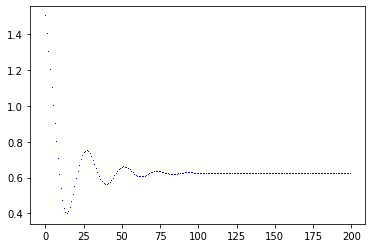

In [5]:
its = range(n_epochs)
plt.plot(its, x1s, "b,")
plt.show()

(c)

In [6]:
n = 1000
xmin, xmax = 0,2
x1 = torch.linspace(xmin, xmax,n, requires_grad=True)
L = get_L(x1,x2)
gradL = torch.zeros_like(L)
for i in range(n):
    L[i].backward(retain_graph=True)
    gradL[i] = x1.grad[i]

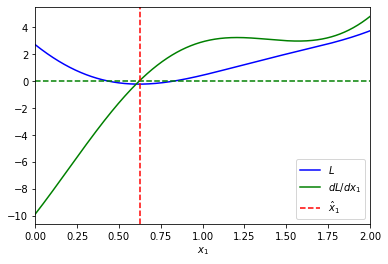

In [7]:
plt.plot(x1.detach().numpy(), L.detach().numpy(), "b-", label=r"$L$")
plt.plot(x1.detach().numpy(), gradL.detach().numpy(), "g-", label=r"$dL/dx_1$")
plt.plot(x1.detach().numpy(), np.zeros(n), "g--")
ymin, ymax = plt.ylim()
plt.vlines(.6241, ymin, ymax, color="r", linestyle="--", label=r"$\hat x_1$")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.xlabel(r"$x_1$")
plt.legend()
plt.show()

# 2) Amplitude Regression

In [8]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data04"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-2-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data04

100%|██████████| 11/11 [00:01<00:00,  9.15it/s]

 tutorial-2-data/  'tutorial-2-data (1).zip'*   tutorial-2-data.zip*


In [2]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


(a)

In [6]:
def get_init_pi(ev, i):
    """ sums z component of incoming particle's momenta"""
    return ev[:, 0, i] + ev[:, 1, i]

def get_pt(fv):
    """ returns p_T of given four vector """
    ptsq = np.round(fv[:, 1]**2 + fv[:, 2]**2, 5)
    return np.sqrt(ptsq)

def get_met(fv):
    """ returns MET of the event"""
    return np.sqrt(np.sum(fv[:, :, 1], axis=1)**2
                   +np.sum(fv[:, :, 2], axis=1)**2)

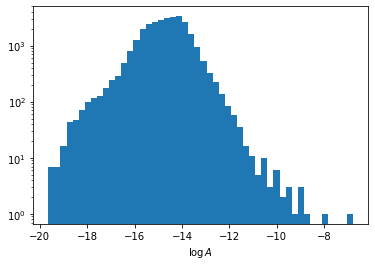

In [11]:
plt.yscale("log")
plt.hist(np.log(trn_amp), bins=50)
plt.xlabel(r"$\log A$")
plt.show()

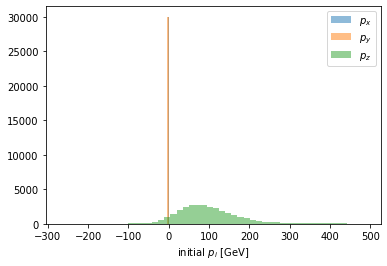

In [12]:
plt.hist(get_init_pi(trn_dat, 1), label=r"$p_x$", alpha=.5, bins=50)
plt.hist(get_init_pi(trn_dat, 2), label=r"$p_y$", alpha=.5, bins=50)
plt.hist(get_init_pi(trn_dat, 3), label=r"$p_z$", alpha=.5, bins=50)
plt.xlabel(r"initial $p_i$ [GeV]")
plt.legend()
plt.show()

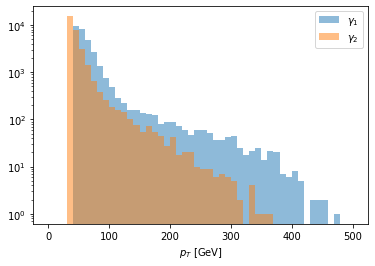

In [13]:
plt.yscale("log")
plt.hist(get_pt(trn_dat[:,2]), alpha=.5, range=(0, 500), label=r"$\gamma_1$", bins=50)
plt.hist(get_pt(trn_dat[:,3]), alpha=.5, range=(0, 500), label=r"$\gamma_2$", bins=50)
plt.xlabel(r"$p_T$ [GeV]")
plt.legend()
plt.show()

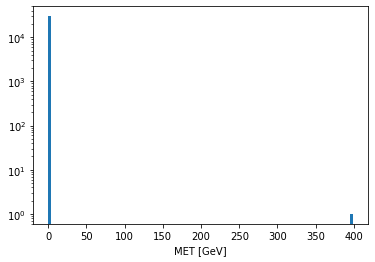

In [7]:
plt.yscale("log")
plt.hist(get_met(trn_dat), bins=100)
plt.xlabel(r"MET [GeV]")
plt.show()

- Log preprocessing for $A$ very be useful
- MET: Should be zero. The event with $\mathrm{MET}\neq 0$ is a bug in the dataset

(b)

In [15]:
# flatten datasets
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

In [16]:
def preprocess_x(x_in, mean=None, std=None):
    x = x_in.copy() # do not overwrite
    if mean is None or std is None:
        mean = x.mean(keepdims=True)
        std = x.std(keepdims=True)
    x = (x - mean) / std # standardize
    assert np.isfinite(x).all() # check for nans and infs
    return torch.Tensor(x).float(), mean, std # create torch tensors
    
def preprocess_A(A_in, mean=None, std=None):
    A = A_in.copy()
    A = np.log(A)
    if mean is None or std is None:
        mean = A.mean(keepdims=True)
        std = A.std(keepdims=True)
    A = (A - mean) / std
    assert np.isfinite(A).all() 
    return torch.tensor(A).float().unsqueeze(-1), mean, std

def undo_preprocess_A(A_in, mean, std):
    A = A_in.copy()
    A = A * std + mean
    A = np.exp(A)
    return A

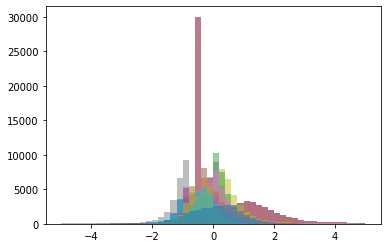

In [17]:
# check that network inputs are O(1)
for i in range(20):
    plt.hist(preprocess_x(trn_datf)[0][:,i], range=(-5,5), alpha=.5, bins=50)
plt.hist(preprocess_A(trn_amp)[0][:,0], range=(-5,5), alpha=.5, bins=50)
plt.show()

In [18]:
class amp_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [19]:
# create datasets and dataloaders
trn_datfp, mean_x, std_x = preprocess_x(trn_datf)
val_datfp, _, _ = preprocess_x(val_datf, mean_x, std_x)
tst_datfp, _, _ = preprocess_x(tst_datf, mean_x, std_x)

trn_ampp, mean_A, std_A = preprocess_A(trn_amp)
val_ampp, _, _ = preprocess_A(val_amp, mean_A, std_A)
tst_ampp, _, _ = preprocess_A(tst_amp, mean_A, std_A)

trn_dataset = amp_dataset(trn_datfp, trn_ampp)
val_dataset = amp_dataset(val_datfp, val_ampp)
tst_dataset = amp_dataset(tst_datfp, tst_ampp)

batch_size = 64
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
tst_dataloader = torch.utils.data.DataLoader(tst_dataset, batch_size=batch_size, shuffle=False)

(c)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [21]:
class amp_net(nn.Module):
    
    def __init__(self, hdn_dim=32, ipt_dim=20, opt_dim=1, n_layers=2):
        super(amp_net, self).__init__()
        
        assert n_layers>=2
        
        layers = []
        layers.append(nn.Linear(ipt_dim, hdn_dim))
        layers.append(nn.ReLU())
        for _ in range(n_layers-2):
            layers.append(nn.Linear(hdn_dim, hdn_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hdn_dim, opt_dim))
        
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [22]:
model = amp_net(hdn_dim=32, n_layers=4).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 2817 trainable parameters


In [23]:
x, A = next(iter(trn_dataloader))
print(x.shape, A.shape)

torch.Size([64, 20]) torch.Size([64, 1])


In [24]:
niterations = 10000
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for it in range(niterations):
    optimizer.zero_grad()
    
    pred = model(x)
    loss = loss_fn(pred, A)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if it%1000==0:
        print(f"{it} / {niterations}")

0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000


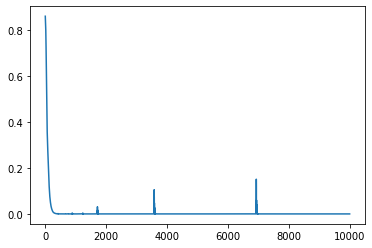

In [25]:
plt.plot(range(niterations), losses)
plt.show()

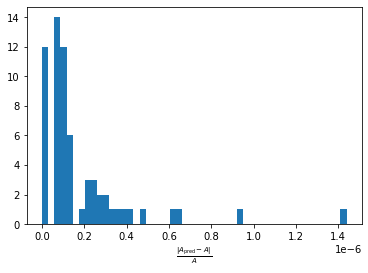

In [26]:
pred = model(x)
diff = torch.abs((pred.detach() - A) / A).cpu().numpy()

plt.hist(diff, bins=50)
plt.xlabel(r"$\frac{|A_\mathrm{pred}-A|}{A}$")
plt.show()

(d)

In [27]:
def batch_loss(model, x, y):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    return loss

In [28]:
def train_epoch(model, dataloader, losses, batch_loss_fn):
    #iterator = iter(dataloader)
    #for i in range(len(dataloader)):
    for x, y in dataloader:
        #x, y = next(iterator)
        optimizer.zero_grad()
        
        loss = batch_loss_fn(model, x, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [29]:
def val_epoch(model, dataloader, losses, batch_loss_fn):
    losses_epoch = []
    with torch.no_grad():
        for x, y in dataloader:
            loss = batch_loss_fn(model, x,y)
            losses_epoch.append(loss.item())
    losses.append(np.mean(losses_epoch))
    return losses

In [30]:
n_epochs = 100
loss_fn = nn.MSELoss()

model = amp_net(hdn_dim=32, n_layers=4).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, val_losses, batch_loss)
    
    if epoch%10==0:
        print(f"{epoch} / {n_epochs}")

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 2817 trainable parameters
0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


In [31]:
def evaluate():
    # plot loss
    plt.yscale("log")
    plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses)
    plt.plot(np.arange(len(val_losses)), val_losses)
    plt.show()
    
    # calculate predictions
    predsp = np.array([])
    model.eval()
    with torch.no_grad():
        for x, y in tst_dataloader:
            pred = model(x)
            predsp = np.append(predsp, pred)

    # undo preprocessing
    preds = undo_preprocess_A(predsp, mean_A, std_A) 
    
    #plt.yscale("log")
    plt.hist(np.log(preds), alpha=.5, range=(-20, -8), bins=50)
    plt.hist(np.log(tst_amp), alpha=.5, range=(-20, -8), bins=50)
    plt.xlabel(r"$\log A$")
    plt.show()

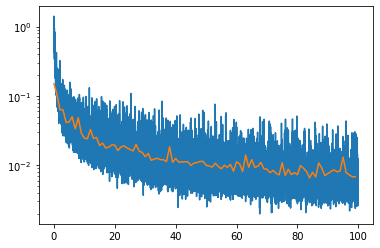

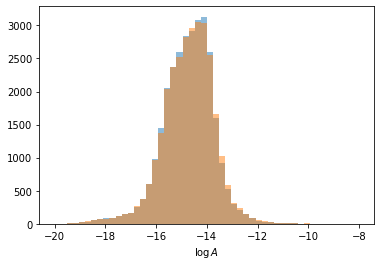

In [32]:
evaluate()

(e)

In [33]:
# create datasets and dataloaders
trn_dataset = amp_dataset(trn_datfp[:1000,:], trn_ampp[:1000,:])
val_dataset = amp_dataset(val_datfp, val_ampp)
tst_dataset = amp_dataset(tst_datfp, tst_ampp)

batch_size = 64
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
tst_dataloader = torch.utils.data.DataLoader(tst_dataset, batch_size=batch_size, shuffle=False)

In [34]:
n_epochs = 100
loss_fn = nn.MSELoss()

model = amp_net(hdn_dim=32, n_layers=4).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, val_losses, batch_loss)
    
    if epoch%10==0:
        print(f"{epoch} / {n_epochs}")

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 2817 trainable parameters
0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


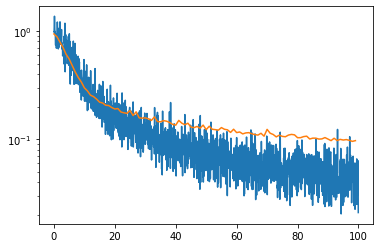

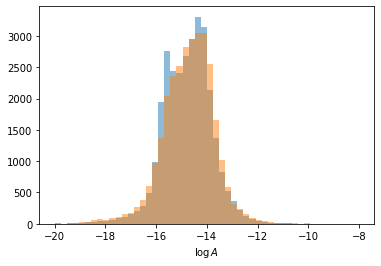

In [35]:
evaluate()

### Early stopping

In [36]:
n_epochs = 100
loss_fn = nn.MSELoss()

model = amp_net(hdn_dim=32, n_layers=4).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

patience = 10
n_patient = 0
batches_per_epoch = len(trn_dataloader)
for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, val_losses, batch_loss)
    
    if np.mean(train_losses[-batches_per_epoch:]) < val_losses[-1]:
        n_patient += 1
    if n_patient == patience:
        print(f"Early stopping in epoch {epoch} with patience={patience}")
        break
    
    if epoch%10==0:
        print(f"{epoch} / {n_epochs}")

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 2817 trainable parameters
0 / 100
10 / 100
Early stopping in epoch 16 with patience=10


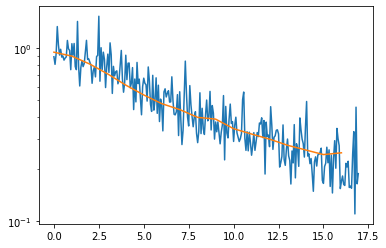

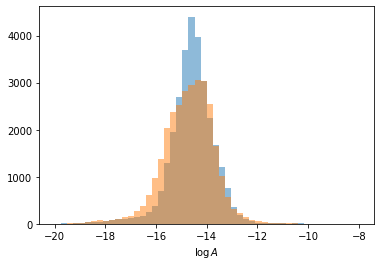

In [37]:
evaluate()

### Dropout

In [40]:
class amp_net(nn.Module):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__(self, hdn_dim=32, ipt_dim=20, opt_dim=1, n_layers=2, dropout=0.):
        super(amp_net, self).__init__()
        
        assert n_layers>=2
        
        layers = []
        layers.append(nn.Linear(ipt_dim, hdn_dim))
        layers.append(nn.ReLU())
        for _ in range(n_layers-2):
            layers.append(nn.Linear(hdn_dim, hdn_dim))
            if dropout>0.:
                layers.append(nn.Dropout(p=dropout))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hdn_dim, opt_dim))
        
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [41]:
n_epochs = 100
loss_fn = nn.MSELoss()

model = amp_net(hdn_dim=64, n_layers=4, dropout=.5).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, val_losses, batch_loss)
    
    if epoch%10==0:
        print(f"{epoch} / {n_epochs}")

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
Model has 9729 trainable parameters
0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


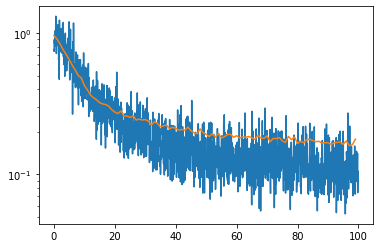

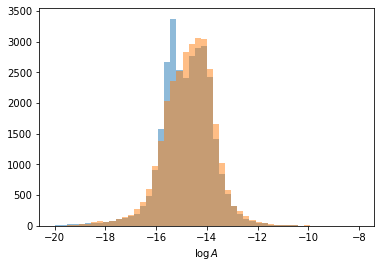

In [42]:
evaluate()

### Weight decay

In [43]:
n_epochs = 100
loss_fn = nn.MSELoss()

model = amp_net(hdn_dim=32, n_layers=4).to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

learning_rate = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                             weight_decay=.5)
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, val_losses, batch_loss)
    
    if epoch%10==0:
        print(f"{epoch} / {n_epochs}")

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 2817 trainable parameters
0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


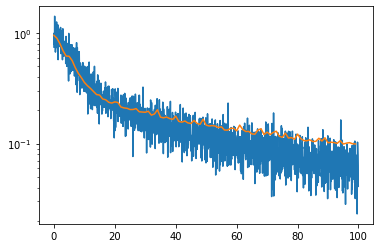

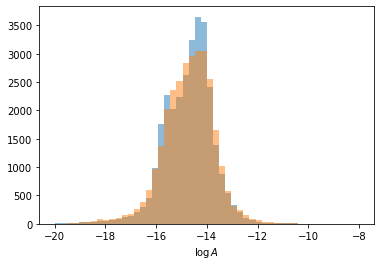

In [44]:
evaluate()